In [1]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import qacits.qacits_vlt_package_v4 as qacits
from photutils import CircularAperture, aperture_photometry
from configobj import ConfigObj
import os
from scipy.stats import linregress
from pathlib import Path

In [2]:
os.chdir('/Users/cdelacroix/CODE/Python/qacits/')
file_dir = 'test'
data_directory = 'data/L_band/'
img_cube_file = 'calib.fits'
psf_file = 'offaxis_PSF_L_CVC.fits'
offset_file = 'calib_tt.fits'

In [3]:
# frame numbers
sci_cube = np.float32(fits.getdata(data_directory+img_cube_file))
#psf_cube = fits.getdata(data_directory+psf_file)[0]
psf_cube = fits.getdata(data_directory+psf_file)
if len(psf_cube.shape) > 2:
    psf_cube = psf_cube[-1]
print('sci_cube.shape',sci_cube.shape)
print('psf_cube.shape',psf_cube.shape)
if sci_cube.shape[1] % 2. != 0:
    dim = sci_cube.shape[1]-1.
if psf_cube.shape[1] % 2. != 0:
    dimpsf = psf_cube.shape[1]-1.
frame_num = np.arange(sci_cube.shape[0])

sci_cube.shape (220, 403, 403)
psf_cube.shape (403, 403)


In [4]:
offset_tab = fits.getdata(data_directory+offset_file).T
threshold=25.
if np.max(offset_tab > threshold):
    index=(np.where(offset_tab[:,0] < threshold))[0]
    print('index',index)
    sci_cube = sci_cube[index]
    offset_tab = offset_tab[index]
    frame_num = np.arange(sci_cube.shape[0])
print('sci_cube shape',sci_cube.shape)
print('offset_tab shape',offset_tab.shape)
offset_x = offset_tab[:,0] #offset_tab['col2'][img_0:img_1]
offset_y = offset_tab[:,1] #offset_x*0. #offset_tab['col3'][img_0:img_1]
offset_m = np.sqrt(offset_x**2+offset_y**2)
print('offset_m shape',offset_m.shape)

sci_cube shape (220, 403, 403)
offset_tab shape (220, 2)
offset_m shape (220,)


In [5]:
### User parameters ###
sci_dit        = 1.
psf_dit        = 1.
#image_sampling = 6.5
#resol = 11.25e-6/8.18*180./np.pi*3600*1e3/45. # # pixels x resol element
image_sampling  = 3.89 #3.97 #4.01 #4.00 #4.05 #4.1 #4.2 #4.3 #4.0
#resol = 3.8112e-6/36.91*180./np.pi*3600*1e3/5.47 # # pixels x resol element
resol = 3.8112e-6/39.9988*180./np.pi*3600*1e3/5.47 # # pixels x resol element
#-- vortex center position -- assumed to be known
vortex_cx       = dim/2.  #sci_cube.shape[1]/2. #409.2 #430.8 # 430.2
vortex_cy       = dim/2. #sci_cube.shape[2]/2. #281.1 #5 #286.9 # 287.8
#-- approximate off-axis PSF position -- assumed to be known (chop throw or known offset)
psf_cx          = dimpsf/2. #psf_cube.shape[0]/2. #32. #192.
psf_cy          = dimpsf/2.#psf_cube.shape[1]/2. #32. #475.
#-- number of averaged frames
n_bin           = 0 # if 0: no averaging, every estimates are returned in a 2D array
                    # if 1: average all frames before computing the estimate
                    # if n_bin=integer < n_img: will return as many estimates (frames are 
                    # averaged by bins of n_img/n_bin before computing the estimates).
#-- display option
disp_plots      = True
save_plots      = True
colors = {'inner':[0.,0.3,.7],'outer':[.7,0.,0.3],'full':[0.,.7,0.5]}

In [6]:
# File with QACITS model parameters
#MODEL = 'old-model'
#MODEL = 'new-model'
MODEL = 'no-model'
#MODEL = 'model_v201907'
if MODEL.find('old-model') > -1:
    parameter_file = 'qacits_model_params_near002.ini'
elif MODEL.find('new-model') > -1 : 
    parameter_file = 'qacits_model_params_near002_new.ini'
elif MODEL.find('no-model') > -1 :
    parameter_file = 'qacits_model_params_noinstr.ini'
elif MODEL.find('model_v201907') > -1 : 
    parameter_file = 'qacits_model_params_near002_v201907.ini'

psf_yx [[201.00000001 201.        ]]
mean_psf_yx [201.00000001 201.        ]
psf_cube_binned shape (403, 403)
psf_cube_binned min/max 6.4909094e-17 0.026340522


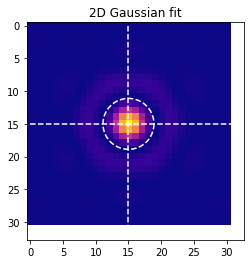

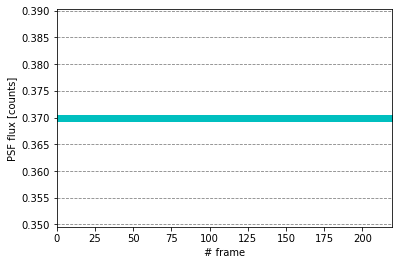

In [7]:
# PSF coord estimate
psf_yx = qacits.get_psf_coordinates(psf_cube, 
                                    cyx_guess=(psf_cy,psf_cx),
                                    sigma_guess = image_sampling/2.)
mean_psf_yx = np.mean(psf_yx, axis=0)
print('psf_yx',psf_yx)
print('mean_psf_yx',mean_psf_yx)
# PSF flux estimate
psf_rad_lbdd = 1. # lambda/D
if len(psf_cube.shape) > 2:
    psf_cube_binned = qacits.bin_images(psf_cube, n_bin)
else:
    psf_cube_binned = psf_cube
print('psf_cube_binned shape',psf_cube_binned.shape)
print('psf_cube_binned min/max',np.min(psf_cube_binned),np.max(psf_cube_binned))
psf_cube_flux = qacits.get_psf_flux_v7(psf_cube_binned, psf_rad_lbdd, image_sampling,
                            cyx_guess=mean_psf_yx, t_int = psf_dit/sci_dit,
                            display=disp_plots, do_norm=False)
if len(psf_cube.shape) == 2:
    psf_cube_flux = np.full(len(frame_num),psf_cube_flux)
mean_psf_flux = np.mean(psf_cube_flux)
plt.figure(num=30)
plt.clf()
plt.plot(frame_num, psf_cube_flux, 'co')
#plt.hlines(mean_psf_flux, np.min(frame_num), np.max(frame_num), color='c', linestyle=':')
plt.xlim(np.min(frame_num), np.max(frame_num))
plt.xlabel('# frame')
plt.ylabel('PSF flux [counts]')
plt.grid(axis='y', color='.5', linestyle='--')

Ienc_ELT 0.026340522
psf shape (403, 403)


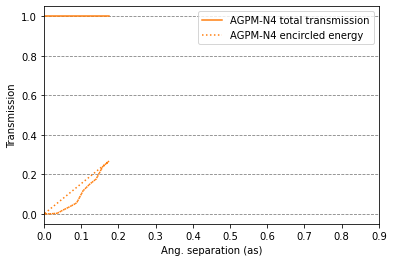

In [8]:
# The binning factor will depend on the number of frames needed to build up
# a sufficient SNR (needs to be studied)
sci_cube_binned = qacits.bin_images(sci_cube, n_bin)

# REFERENCE IMAGE SUBTRACTION
#sci_cube_binned = sci_cube_binned - np.median(sci_cube_binned[0:5], axis=0)

# Rejection rate estimate
region_rad_lbdd = 1. # lambda/D
#coro_cube_flux = qacits.get_psf_flux_v7(sci_cube_binned, region_rad_lbdd, image_sampling,
#                            cyx_guess=(vortex_cy, vortex_cx), t_int = psf_dit/sci_dit,
#                            display=disp_plots, do_norm=False, no_fit=True)
if len(psf_cube.shape) > 2:
    psf_cube_binned_tot = qacits.bin_images(psf_cube, 1)
else:
    psf_cube_binned_tot = psf_cube
#psf_flux = qacits.get_psf_flux(psf_cube_binned_tot, region_rad_lbdd, image_sampling,
#                            cyx_guess=mean_psf_yx, t_int = psf_dit/sci_dit,
#                            display=disp_plots, do_norm=False, no_fit=True)
modes = ['AGPM-N4']
colors = {'RAVC': 'C2',
           'AGPM-N4': 'C1',
           'CLC': 'C0',
           'APP': 'C3'}
FWHM = resol #image_sampling
rad = 0.317*FWHM/2. #1.4*FWHM/2
# encircled energy of ELT mode (no corono)
#Ienc_ELT = 15745.403521666532
apertures = CircularAperture((psf_cx, psf_cy), r=rad)
#apertures = CircularAperture((psf_cx, psf_cy)-*FWHM, r=FWHM/2)
#apertures = CircularAperture((psf_cx, psf_cy)-offset_tabpsf[-1,:]*FWHM, r=FWHM/2)
apertures = CircularAperture((psf_cx, psf_cy)-offset_tab[-1,:]*FWHM, r=rad)
#print('(psf_cx, psf_cy)-offset_tab[-1,:]*FWHM',(psf_cx, psf_cy)-offset_tab[-1,:]*FWHM)
#Ienc_ELT=aperture_photometry(psf_cube_binned_tot, apertures)['aperture_sum'].data[0]
Itot_ELT=np.sum(psf_cube_binned_tot)
Ienc_ELT=aperture_photometry(sci_cube_binned[-1], apertures)['aperture_sum'].data[0]
#Ienc_ELT = np.sum(sci_cube_binned[-1]) #psf_cube_binned_tot)
Ienc_ELT = np.max(psf_cube_binned_tot)
print('Ienc_ELT',Ienc_ELT)
print('psf shape',psf_cube_binned_tot.shape)
# calculate off-axis transmissions
frames = sci_cube_binned
tip_tilt_array = offset_tab
x = offset_m*1. #[:,0]#*lamoverD*1e-3
cx = vortex_cx
cy = vortex_cy
for mode in modes:
    # aperture photometry
    Ienc = []
    Itot = []
    for (frame, tip_tilt) in zip(frames, tip_tilt_array):
        #print('tip_tilt',tip_tilt)
        #print('(cx, cy) - tip_tilt*FWHM',(cx, cy) - tip_tilt*FWHM)
        #apertures = CircularAperture((cx, cy) - tip_tilt*FWHM, r=rad)
        #Ienc.append(aperture_photometry(frame, apertures)['aperture_sum'].data[0])
        #Itot.append(np.sum(frame))
        #print('pos PSF coro',int((cx-tip_tilt*FWHM)[0]),int((cy-tip_tilt*FWHM)[1]))
        Ienc.append(frame[int((cy-tip_tilt*FWHM)[1]),int((cx-tip_tilt*FWHM)[0])])
        Itot.append(np.max(psf_cube_binned_tot))
 # total transmission
    #print('Itot',Itot)
    #Ttot = Itot/Itot_ELT
    Ttot = Itot/Itot[-1] #*trans[mode]
    # encircled energy
    #print('Ienc',Ienc)
    Tenc = np.array(Ienc)/Ienc_ELT
#attenuation = psf_cube_flux/coro_cube_flux
x *= image_sampling*0.045
plt.figure(num=31)
plt.clf()
#plt.plot(frame_num, attenuation, 'co')
#plt.plot(offset_m*image_sampling*0.045, attenuation, 'co')
plt.plot(x,Ttot,label='%s total transmission'%mode, color=colors[mode])
plt.plot(x,Tenc,':',label='%s encircled energy'%mode, color=colors[mode])
#plt.xlim(np.min(frame_num), np.max(frame_num))
plt.xlim(0., .9)
#plt.xlim(0., 6.)
#plt.ylim(0, 30)
#plt.xlabel('# frame')
plt.xlabel('Ang. separation (as)')
#plt.ylabel('Attenuation')
plt.ylabel('Transmission')
plt.grid(axis='y', color='.5', linestyle='--')
plt.legend(frameon=True);
#plt.title("Flux attenuation within a radius of {} $\lambda$/D\n".format(int(region_rad_lbdd)))

qacits_params {'radii': {'inner': (0.0, 1.7), 'outer': (1.7, 2.3), 'full': (0.0, 1.7)}, 'inner_slope': 1.0, 'outer_slope': 1.0, 'full_coeff': 1.0, 'ratio': 0.0, 'phase_tolerance': 60.0, 'modul_tolerance': 0.33, 'small_tt_regime': 0.3, 'large_tt_regime': 0.2}
slopes  {'inner': 0.14877232818915248, 'outer': 0.0634897769188975, 'full': -0.2747383111764589}


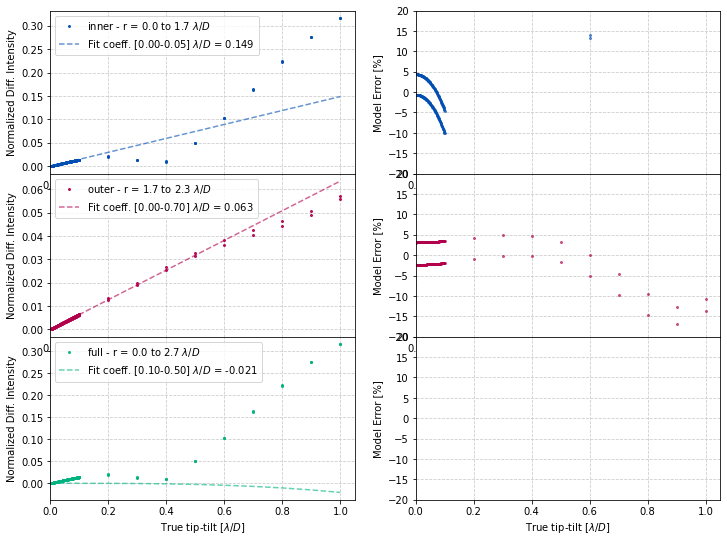

In [9]:
file  = open(data_directory+'transmission_agpm_near.dat', 'w')
file.write('#Separation (as)   Transm. NEAR AGPM total energy + encircled energy')
for ii in range(len(Ttot)):
    #file.write('{}'.format(fs_lod[:,ii]))
    file.write('\n{} {} {}'.format(x[ii],Ttot[ii], Tenc[ii]))
file.close()
### normalization by PSF flux ##################################################
for i, im in enumerate(sci_cube_binned):
    sci_cube_binned[i] = im/psf_cube_flux[i]
mean_psf_flux  = 1.
### Tip-tilt estimate #########################################################
qacits_params = ConfigObj(parameter_file, unrepr=True)
print('qacits_params',qacits_params)
tiptilt_estimate_full = qacits.quadrant_tiptilt_v7b(qacits_params, sci_cube_binned,
                                         (vortex_cy,vortex_cx), 
                                         mean_psf_flux, 
                                         image_sampling, 
                                         verbose=False, exact=True,
                                         force = None)
#--- Final estimator
tiptilt_estimate = tiptilt_estimate_full[:,0:2]
#--- Other estimators (r, theta)
inner_rt = tiptilt_estimate_full[:,2:4] 
outer_rt = tiptilt_estimate_full[:,4:6] 
full_rt = tiptilt_estimate_full[:,6:8] 
#--- conversion in (x,y)
tt_shape = tiptilt_estimate.shape
inner_xy = np.zeros(tt_shape)
inner_xy[:,0] = inner_rt[:,0] * np.cos(inner_rt[:,1])
inner_xy[:,1] = inner_rt[:,0] * np.sin(inner_rt[:,1])
outer_xy = np.zeros(tt_shape)
outer_xy[:,0] = outer_rt[:,0] * np.cos(outer_rt[:,1])
outer_xy[:,1] = outer_rt[:,0] * np.sin(outer_rt[:,1])
full_xy = np.zeros(tt_shape)
full_xy[:,0] = full_rt[:,0] * np.cos(full_rt[:,1])
full_xy[:,1] = full_rt[:,0] * np.sin(full_rt[:,1])
# TT SCAN DATA: MODEL CALIBRATION
colors = {'inner':[0.,0.3,.7],'outer':[.7,0.,0.3],'full':[0.,.7,0.5]}
slopes = {}
model_order = {'inner':1,'outer':1,'full':3}
plt.figure(num=17, figsize=(12,9))
plt.clf()
fig, ax = plt.subplots(nrows=3,ncols=2,num=17)
fig.subplots_adjust(hspace=0) #wspace=0
tt_fit_lim  = {'inner': (0., 0.05),
               'outer': (0., 0.7),
               'full':  (0.1, 0.5)}
ind_sort = np.argsort(offset_m)
calib_tt = offset_m[ind_sort]
radii = {'inner': (0.0, 1.7), 'outer': (1.7, 2.3), 'full':  (0., 2.7)}
for i, region in enumerate(tt_fit_lim):
    ind_x = np.where((calib_tt>tt_fit_lim[region][0]) & 
                     (calib_tt<tt_fit_lim[region][1]))[0]
    x = calib_tt[ind_x]
    if   region == 'inner':
        yy  = inner_rt[ind_sort,0]
    elif region == 'outer':
        yy  = outer_rt[ind_sort,0]
    elif region == 'full':
        yy  = full_rt[ind_sort,0]
    y = yy[ind_x]
    lin_params = linregress(x,y)
    slopes[region] = lin_params.slope
#            ax[i].set_title(region)
    ax[i,0].set_xlabel(r'True tip-tilt [$\lambda/D$]')
    ax[i,0].set_ylabel('Normalized Diff. Intensity')
    ax[i,0].plot(calib_tt, yy**model_order[region], 'o', 
               color=colors[region], alpha=.9, markersize=2,
               label=region+r' - r = {0:.1f} to {1:.1f} $\lambda/D$'
               .format(radii[region][0], radii[region][1]))
    ax[i,0].plot(calib_tt, calib_tt**model_order[region]*slopes[region]**model_order[region], 
               color=colors[region], alpha=.6, linestyle='--', 
               label=r'Fit coeff. [{0:.2f}-{1:.2f}] $\lambda/D$ = {2:.3f}'
               .format(tt_fit_lim[region][0],tt_fit_lim[region][1],slopes[region]**model_order[region]))
    ax[i,0].grid(color='.8',linestyle='--')
    ax[i,0].set_xlim(0.,)
#            ax[i,0].set_ylim(0.,.0s07)
    ax[i,0].legend()
    
    error = ((yy**model_order[region] - 
              calib_tt**model_order[region]*slopes[region]**model_order[region]) /
              yy**model_order[region]) * 100.
    ax[i,1].set_xlabel(r'True tip-tilt [$\lambda/D$]')
    ax[i,1].set_ylabel('Model Error [%]')
    ax[i,1].plot(calib_tt, error, 
               'o', markersize=2, color=colors[region], alpha=.6)
    ax[i,1].set_ylim(-20., 20.)
    ax[i,1].set_xlim(0.,)
    ax[i,1].grid(color='.8',linestyle='--')

print('slopes ', slopes)

n_tt 220


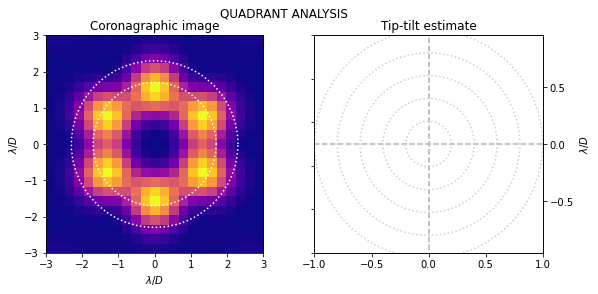

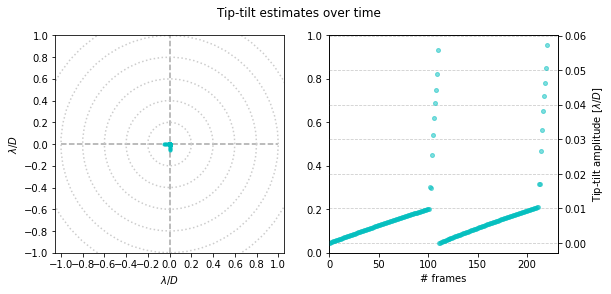

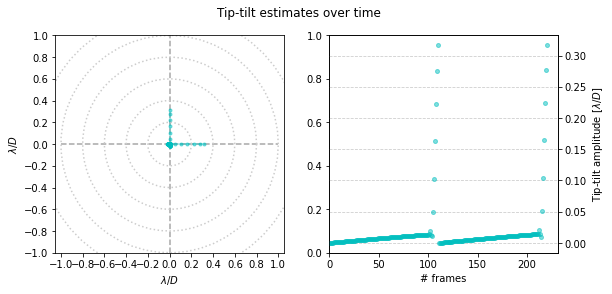

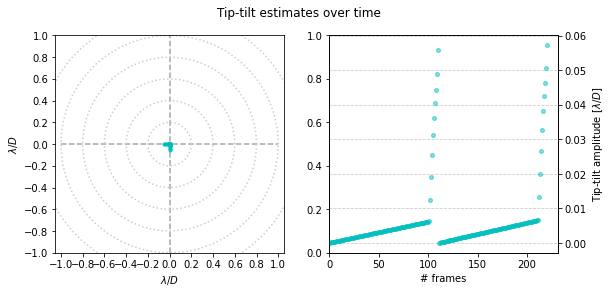

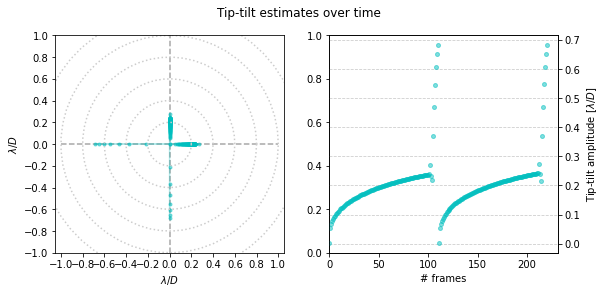

offset_m min/max 0.0 1.0
time_axis dim 220
offset_m dim 220
offset_m min/max 0.0 1.0
time_axis dim 220
offset_m dim 220
offset_m min/max 0.0 1.0
time_axis dim 220
offset_m dim 220
offset_m min/max 0.0 1.0
time_axis dim 220
offset_m dim 220


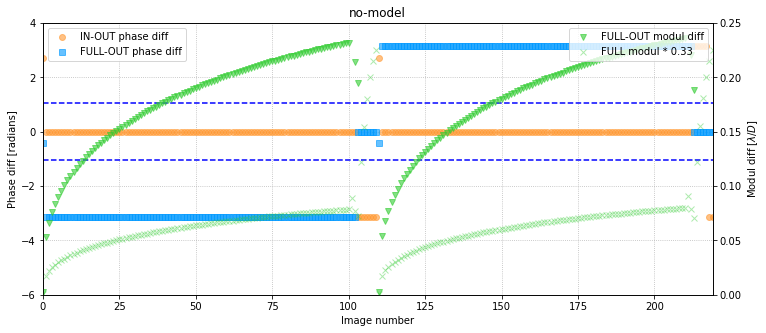

In [10]:
## DISPLAY ###################################################################
if disp_plots is True:    
    #-- Conversion in polar coordinates
    tt_rt = np.zeros_like(tiptilt_estimate)
    tt_rt[:,0] = np.sqrt(tiptilt_estimate[:,0]**2+tiptilt_estimate[:,1]**2)
    tt_rt[:,1] = np.arctan2(tiptilt_estimate[:,1],tiptilt_estimate[:,0]) * 180./np.pi
    #-- some parameters for display
    subim_width_lbdd = 3.
    inner_rad_lbdd  = 1.7
    outer_rad_lbdd  = 2.3
    #-- Quadrant analysis results for the last image
    img_i = 0 #20
    delta_t = None #0.016666666 #0.2166
    n_tt = len(tiptilt_estimate[:,0])
    time_axis = frame_num
    fig1, ax1 = qacits.display_tiptilt_target(sci_cube_binned[img_i], image_sampling, (vortex_cy, vortex_cx),
                                       tiptilt_estimate[img_i], subim_width_lbdd=subim_width_lbdd, 
                                       fig_num=41, tt_lim=1., plot_title='QUADRANT ANALYSIS',
                                       img_circ_rad=(inner_rad_lbdd, outer_rad_lbdd), 
                                       tt_circ_rad=(.2,.4,.6,.8,1.))
    #-- plot all estimates
    suffix = ''
    tt = (0,n_tt)
    print('n_tt',n_tt)
    tt_circ_rad = (.2,.4,.6,.8,1., 1.2)
    fig2, ax2 = qacits.display_tiptilt_sequence(tiptilt_estimate[tt[0]:tt[1]], delta_t=delta_t, #time_axis=frame_num,
                                         tt_circ_rad=tt_circ_rad, 
                                         fignum=42) #, title=MODEL)
    fig3, ax3 = qacits.display_tiptilt_sequence(inner_xy[tt[0]:tt[1]], delta_t=delta_t, #time_axis=frame_num,
                                         tt_circ_rad=tt_circ_rad, 
                                         fignum=50) #, color='b') #, title='Inner Estimator {}'.format(MODEL))
    fig4, ax4 = qacits.display_tiptilt_sequence(outer_xy[tt[0]:tt[1]], delta_t=delta_t, #time_axis=frame_num,
                                         tt_circ_rad=tt_circ_rad, 
                                         fignum=51) #, color='r') #, title='Outer Estimator {}'.format(MODEL))
    fig5, ax5 = qacits.display_tiptilt_sequence(full_xy[tt[0]:tt[1]], delta_t=delta_t, #time_axis=frame_num,
                                         tt_circ_rad=tt_circ_rad, 
                                         fignum=52) #, color='g')# title='Full Estimator {}'.format(MODEL))
    plt.show(block=True)
    #There seems to be rescaling of the field selector amplitudes in the right plots
    #depending on the selected estimator?!
    #-- Add the FS position to the plots
    target_ax = [ax2[0], ax3[0], ax4[0], ax5[0]]
    fs_color = '.7'
    fs_symbol = '+'
    for aa in target_ax :
        aa.plot(offset_x, offset_y, marker = fs_symbol, color=fs_color)
    time_ax = [ax2[1], ax3[1], ax4[1], ax5[1]]
    for bb in time_ax :
        print('offset_m min/max',np.min(offset_m),np.max(offset_m))
        print('time_axis dim',len(time_axis))
        print('offset_m dim',len(offset_m))
        bb.plot(time_axis,offset_m, fs_symbol, color=fs_color, label='Field Selector Position')
        bb.set_ylim(0, np.max(offset_m)) #np.max(tt_circ_rad))
        bb.set_xlim(frame_num[0], frame_num[-1])
        bb.legend()
    inout_phase_diff = tiptilt_estimate_full[:,8:11][:,0]
    fullout_phase_diff = tiptilt_estimate_full[:,8:11][:,1]
    fullout_modul_diff = tiptilt_estimate_full[:,8:11][:,2]
    plt.figure(num=0, figsize=(12,5))
    plt.clf()
    figg, axx = plt.subplots(num=0)
    axx.plot(inout_phase_diff, 'o', label='IN-OUT phase diff', alpha=.6, color=(1,.6,.2))
    axx.plot(fullout_phase_diff, 's', label='FULL-OUT phase diff', alpha=.6, color=(0,.6,1))
    axx.hlines((60.*np.pi/180.,-60.*np.pi/180.), 0, n_tt, color='b', linestyle='--')
    axx.grid(color='.7', linestyle=':')
    axx.set_ylim(-6., 4)
    axx.set_ylabel('Phase diff [radians]')
    axx.set_xlabel('Image number')
    axx.legend(loc=2)
    axx.set_title(MODEL)
    axx2 = axx.twinx()
    axx2.plot(fullout_modul_diff, 'v', label='FULL-OUT modul diff', alpha=.6, color=(.2,.8,.2))
    axx2.plot(full_rt[:,0]*.33, 'x', label='FULL modul * 0.33', alpha=.4, color=(.2,.8,.2))
    #axx2.grid(color='.8', linestyle='--')
    axx2.set_ylim(0,.25)
    axx2.set_ylabel(r'Modul diff [$\lambda/D$]')
    axx2.legend(loc=1)
    axx2.set_xlim(0,n_tt-1)

In [14]:
    if save_plots is True:
        output_directory= data_directory+file_dir+'/{}'.format(MODEL)
        p = Path(output_directory)
        if (p.exists() is False):
            os.makedirs(output_directory)
        plt.figure(num=42)
        plt.savefig(output_directory+'/'+img_cube_file+'_{}_tiptilt_estimator'.format(MODEL)+suffix+'.png', dpi=150, bbox_inches='tight');
        plt.figure(num=50)
        plt.savefig(output_directory+'/'+img_cube_file+'_{}_tiptilt_inner_estimator'.format(MODEL)+suffix+'.png', dpi=150, bbox_inches='tight');
        plt.figure(num=51)
        plt.savefig(output_directory+'/'+img_cube_file+'_{}_tiptilt_outer_estimator'.format(MODEL)+suffix+'.png', dpi=150, bbox_inches='tight');
        plt.figure(num=52)
        plt.savefig(output_directory+'/'+img_cube_file+'_{}_tiptilt_full_estimator'.format(MODEL)+suffix+'.png', dpi=150, bbox_inches='tight');
        plt.figure(num=30)
        plt.savefig(output_directory+'/'+img_cube_file+'_{}_PSF_flux.png'.format(MODEL), dpi=150, bbox_inches='tight');
        plt.figure(num=31)
        plt.savefig(output_directory+'/'+img_cube_file+'_{}_Flux_attenuation.pdf'.format(MODEL), dpi=150, bbox_inches='tight');
        plt.figure(num=0);
        plt.savefig(output_directory+'/'+img_cube_file+'_{}_Estimator_agreement_checks.png'.format(MODEL), dpi=150, bbox_inches='tight');

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>